In [1]:
if False: # cargar modelo de github/mascotas-model-app
  !git clone https://github.com/teamght/mascotas-model-app
  !mv mascotas-model-app/saved_model ./saved_model

In [2]:
if False: # subir y cargar modelo desde pc local
  from google.colab import files

  uploaded = files.upload()

  !mkdir saved_model
  !mv saved_model.pb saved_model/saved_model.pb
  !mkdir variables
  !mv variables.data-00000-of-00001 variables/variables.data-00000-of-00001
  !mv variables.index variables/variables.index
  !mv variables saved_model/variables


In [3]:
if True: # cargar *un* modelo de github/mascotas-general
  !git clone https://github.com/teamght/mascotas-general
  !cp -r mascotas-general/entrenamiento-red/1092 saved_model
  !mkdir saved_model/variables
  !mv saved_model/variables.data-00000-of-00001 saved_model/variables/variables.data-00000-of-00001
  !mv saved_model/variables.index saved_model/variables/variables.index
  !ls mascotas-general/entrenamiento-red/1092

Cloning into 'mascotas-general'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 7), reused 23 (delta 7), pack-reused 0
Unpacking objects: 100% (23/23), done.
Checking out files: 100% (14/14), done.


In [15]:
!ls saved_model
!ls saved_model/variables

saved_model.pb	variables
variables.data-00000-of-00001  variables.index


In [16]:
# LOADING MODEL

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


PATH        = 'dogs-dataset-b-limpio/data/' # Path to the directory of the saved dataset
PATH_MODEL  = './saved_model'      # Path to the directory where the model will be stored
SIZE        = (224,224,3)                               # Size of the input images


#----------------------------------------------------------------------------
# Loss definition.

alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

#----------------------------------------------------------------------------
# Model load

print('Loading model...')

model = tf.keras.models.load_model(PATH_MODEL,
    custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

print('Done')


Loading model...
Done


In [17]:
!git clone -b datasets_limpios_alineados https://gitlab.com/teamghtgcba/dogs-dataset-b-limpio.git

Cloning into 'dogs-dataset-b-limpio'...
remote: Enumerating objects: 60735, done.
remote: Counting objects: 100% (60735/60735), done.
remote: Compressing objects: 100% (60701/60701), done.
remote: Total 60735 (delta 9), reused 60730 (delta 4), pack-reused 0
Receiving objects: 100% (60735/60735), 908.05 MiB | 43.26 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (41169/41169), done.


In [18]:
#!ls dogs-dataset-b-limpio/data/

assert os.path.isdir(PATH), '[Error] Provided PATH for dataset does not exist.'

In [19]:
print('Loading the dataset...')

import os, random
carpetas = sorted([o for o in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, o))])
random.seed(4)
random.shuffle(carpetas)
print(carpetas[:10])

carpetas2 = [(PATH + c, None, os.listdir(os.path.join(PATH, c))) for c in carpetas]

filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root, dirs, files in carpetas2:
    # Directorio / / archivos por directorio (list())
    #print('{} {} {}'.format(root,dirs,files))
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        # Recupera la ruta de todos los archivos
        #print('{}'.format(filenames))
        labels = np.append(labels,np.ones(len(files))*idx)
        # Crea una lista de etiquetas "nombre de las carpetas". Posteriormente se obtendrá las etiquetas únicas
        #print('{}'.format(labels))
        idx += 1

print(filenames)
print(labels)

Loading the dataset...
['50430193', '51293014', '51070822', '51236085', '51298788', '1301', '51286528', '50894180', '51217312', '51202526']
['dogs-dataset-b-limpio/data/50430193/4.jpg'
 'dogs-dataset-b-limpio/data/50430193/3.jpg'
 'dogs-dataset-b-limpio/data/50430193/5.jpg' ...
 'dogs-dataset-b-limpio/data/50556157/2.jpg'
 'dogs-dataset-b-limpio/data/50138359/0.jpg'
 'dogs-dataset-b-limpio/data/50138359/1.jpg']
[    0.     0.     0. ... 12475. 12476. 12476.]


In [20]:
TEST_SPLIT  = 0.05                                       # Test ratio
VAL_SPLIT  = 0.05                                       # Val ratio


print('Total number of imported pictures: {:d}'.format(len(labels)))
nbof_classes = len(np.unique(labels))
print('Total number of classes: {:d}'.format(nbof_classes))

# Split the dataset.
print('\nSplit por las clases de perros que se tienen, no por las imágenes')

nbof_test = int(TEST_SPLIT*nbof_classes)
nbof_val = int(VAL_SPLIT*nbof_classes)

keep_test = np.less(labels, nbof_test) # 111 0000000000000
keep_val_1 = np.greater_equal(labels, nbof_test) # 000 1111111111111
keep_val_2 = np.less(labels, nbof_test + nbof_val) # 1111111111111 000000
keep_val = np.logical_and(keep_val_1, keep_val_2) # 000 1111111111 000000
keep_train = np.greater_equal(labels, nbof_test + nbof_val) # 000000000 1111
'''
print(keep_test)
print(keep_val)
print(keep_train)
print(np.sum(keep_test), np.sum(keep_val), np.sum(keep_train))
'''

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

filenames_val = filenames[keep_val]
labels_val = labels[keep_val]

print("Number of training data: {} pictures".format(str(len(filenames_train))))
print("Number of training classes: {} ({} %)".format(str(nbof_classes-nbof_test-nbof_val), 1 - TEST_SPLIT - VAL_SPLIT))
print("Number of testing data: {} pictures".format(str(len(filenames_test))))
print("Number of testing classes: {} ({} %)".format(str(nbof_test), TEST_SPLIT))
print("Number of validation data: {} pictures".format(str(len(filenames_val))))
print("Number of validation classes: {} ({} %)".format(str(nbof_val), VAL_SPLIT))

Total number of imported pictures: 41142
Total number of classes: 12477

Split por las clases de perros que se tienen, no por las imágenes
Number of training data: 37110 pictures
Number of training classes: 11231 (0.8999999999999999 %)
Number of testing data: 2025 pictures
Number of testing classes: 623 (0.05 %)
Number of validation data: 2007 pictures
Number of validation classes: 623 (0.05 %)


In [21]:
print(filenames_test)
print(labels_test)

['dogs-dataset-b-limpio/data/50430193/4.jpg'
 'dogs-dataset-b-limpio/data/50430193/3.jpg'
 'dogs-dataset-b-limpio/data/50430193/5.jpg' ...
 'dogs-dataset-b-limpio/data/51156646/1.jpg'
 'dogs-dataset-b-limpio/data/51156646/5.jpg'
 'dogs-dataset-b-limpio/data/51156646/2.jpg']
[  0.   0.   0. ... 622. 622. 622.]


In [22]:

def load_images(filenames):
    """
    Use scikit-image library to load the pictures from files to numpy array.
    """
    h,w,c = SIZE
    images = np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
        images[i] = sk.io.imread(f)/255.0
    return images

def predict_generator(filenames, batch_size=32):
    """
    Prediction generator.
    """
    for i in range(0,len(filenames),batch_size):
        print(f'predict_generator: {i} de {len(filenames)}')
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch


In [23]:
## CORRER RED SOBRE TODAS LAS IMÁGENES

pairs = list(filenames_test)
#pairs = list(filenames_val)

predict = model.predict_generator(predict_generator(pairs, 32), steps=np.ceil(len(pairs)/32))


predict_generator: 0 de 2025


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


predict_generator: 32 de 2025
predict_generator: 64 de 2025
predict_generator: 96 de 2025
predict_generator: 128 de 2025
predict_generator: 160 de 2025
predict_generator: 192 de 2025
predict_generator: 224 de 2025
predict_generator: 256 de 2025
predict_generator: 288 de 2025
predict_generator: 320 de 2025
predict_generator: 352 de 2025
predict_generator: 384 de 2025
predict_generator: 416 de 2025
predict_generator: 448 de 2025
predict_generator: 480 de 2025
predict_generator: 512 de 2025
predict_generator: 544 de 2025
predict_generator: 576 de 2025
predict_generator: 608 de 2025
predict_generator: 640 de 2025
predict_generator: 672 de 2025
predict_generator: 704 de 2025
predict_generator: 736 de 2025
predict_generator: 768 de 2025
predict_generator: 800 de 2025
predict_generator: 832 de 2025
predict_generator: 864 de 2025
predict_generator: 896 de 2025
predict_generator: 928 de 2025
predict_generator: 960 de 2025
predict_generator: 992 de 2025
predict_generator: 1024 de 2025
predict_ge

In [24]:
predictions_list = list(predict)

filenames_list = list(filenames_test)
#filenames_list = list(filenames_val)

labels_list = [int(label) for label in labels_test]
#labels_list = [int(label) for label in labels_val]

original_folder_names_list = [int(filename.split("/")[-2]) for filename in filenames_list]


(array([ 310.,    0.,    0.,    0.,    4.,    9.,   12.,   23.,   78.,
       1589.]), array([3.10000000e+01, 5.13550360e+06, 1.02709762e+07, 1.54064488e+07,
       2.05419214e+07, 2.56773940e+07, 3.08128666e+07, 3.59483392e+07,
       4.10838118e+07, 4.62192844e+07, 5.13547570e+07]), <a list of 10 Patch objects>)
310
1715


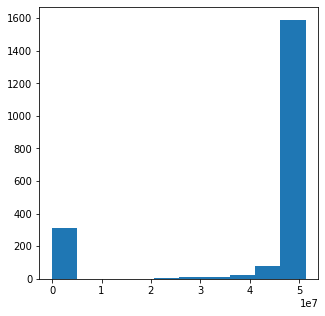

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
histogram = ax.hist(original_folder_names_list, bins=10)

print(histogram)

threshold = 7500000

print(len([x for x in original_folder_names_list if x < threshold]))
print(len([x for x in original_folder_names_list if x >= threshold]))

mask = [x > threshold for x in original_folder_names_list]

def filter_out(xs):
  return [x for c, x in zip(mask, xs) if c]


In [26]:
# filter out original dataset dogs
predictions_list = filter_out(predictions_list)
filenames_list = filter_out(filenames_list)
labels_list = filter_out(labels_list)
original_folder_names_list = filter_out(original_folder_names_list)

In [27]:
print(len(predictions_list))
print(len(filenames_list))
print(len(labels_list))
print(len(original_folder_names_list))

print(predictions_list[30])
print(filenames_list[30])
print(labels_list[30])

1715
1715
1715
1715
[ 0.21619071 -0.02614219 -0.45825928 -0.28971076 -0.02413273  0.22743396
  0.32086238  0.05962664  0.05919366 -0.16743377 -0.18666202  0.30721843
 -0.08950274  0.07639796 -0.20246911  0.19517241 -0.25962317  0.00611117
 -0.10319196  0.19409841  0.11760024 -0.03897614  0.16597681  0.07795532
  0.04700365  0.1200164  -0.16355978 -0.15377595  0.02441716 -0.02097712
 -0.05623402  0.10090222]
dogs-dataset-b-limpio/data/51217312/1.jpg
8


In [28]:
def distance(v1, v2):
  diff = np.square(v1-v2)
  dist = np.sum(diff)
  return dist

In [29]:
pairs_same_img = []
pairs_same_class = []
pairs_different_class = []
for i1, (p1, f1, l1) in enumerate(zip(predictions_list, filenames_list, labels_list)):
  for i2, (p2, f2, l2) in enumerate(zip(predictions_list, filenames_list, labels_list)):
    d = distance(p1, p2)
    score = 1 - d
    pair = (i1, p1, f1, l1, i2, p2, f2, l2, score)
    #print(pair)
    if i1 <= i2:
      if i1 == i2:
        pairs_same_img.append(pair)
      elif l1 == l2:
          pairs_same_class.append(pair)
      else:
          pairs_different_class.append(pair)
print("len(pairs_same_img):", len(pairs_same_img))
print("len(pairs_same_class):", len(pairs_same_class))
print("len(pairs_different_class):", len(pairs_different_class))

len(pairs_same_img): 1715
len(pairs_same_class): 2147
len(pairs_different_class): 1467608


In [30]:
def analize(pairs):
  positives = 0
  negatives = 0
  for i1, p1, f1, l1, i2, p2, f2, l2, score in pairs:
    if score > 0.5:
      positives += 1
    else:
      negatives += 1
  print("positives:", positives)
  print("negatives:", negatives)
  print("ratio:", 1. * positives / (positives + negatives))

In [31]:
print("### pairs_same_img ###")
analize(pairs_same_img)
print("### pairs_same_class ###")
analize(pairs_same_class)
print("### pairs_different_class ###")
analize(pairs_different_class)

### pairs_same_img ###
positives: 1715
negatives: 0
ratio: 1.0
### pairs_same_class ###
positives: 1538
negatives: 609
ratio: 0.7163483931066604
### pairs_different_class ###
positives: 46349
negatives: 1421259
ratio: 0.031581321442783084


In [32]:
print(len(pairs_same_img))
print(len(pairs_same_class))
print(len(pairs_different_class))

n_same = len(pairs_same_class)
n_diff = len(pairs_different_class)

def get_scores(pairs):
  return [score for i1, p1, f1, l1, i2, p2, f2, l2, score in pairs]

def gen_y(val, n):
  return [val for _ in range(n)]

scores = get_scores(pairs_same_class) + get_scores(pairs_different_class)
y = gen_y(1, n_same) + gen_y(0, n_diff)
sample_weights = gen_y(1/n_same, n_same) + gen_y(1/n_diff, n_diff)


1715
2147
1467608


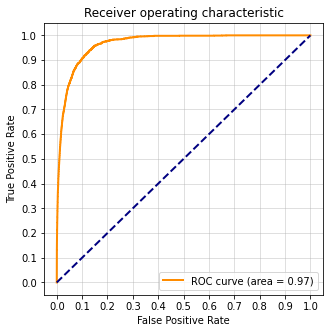

In [33]:
from sklearn.metrics import roc_curve, auc

assert len(scores) == len(y)

fpr, tpr, thresholds = roc_curve(y, scores, sample_weight=sample_weights)

roc_auc = auc(fpr, tpr)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

ticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.grid(alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Ejemplos de clasificaciones extremas

In [34]:
%matplotlib inline
import math

def mostrar_imagenes(imagenes, cols, titles = None, save_path = None):
    n = len(imagenes)
    rows=math.ceil(1.*n/cols)
    fig = plt.figure(figsize=(3*cols,3*rows))
    for ir in range(rows):
        for ic in range(cols):
            i = cols*ir+ic
            if i < n:
                plt.subplot(rows, cols, i+1)
                if titles is not None:
                    title = str(titles[i])
                    fontdict = {'fontweight': 'bold', 'color': 'red'} if "#" in title else {}
                    plt.title(title, fontdict=fontdict)
                plt.imshow(load_images([imagenes[i]])[0])
                plt.xticks([])
                plt.yticks([])
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

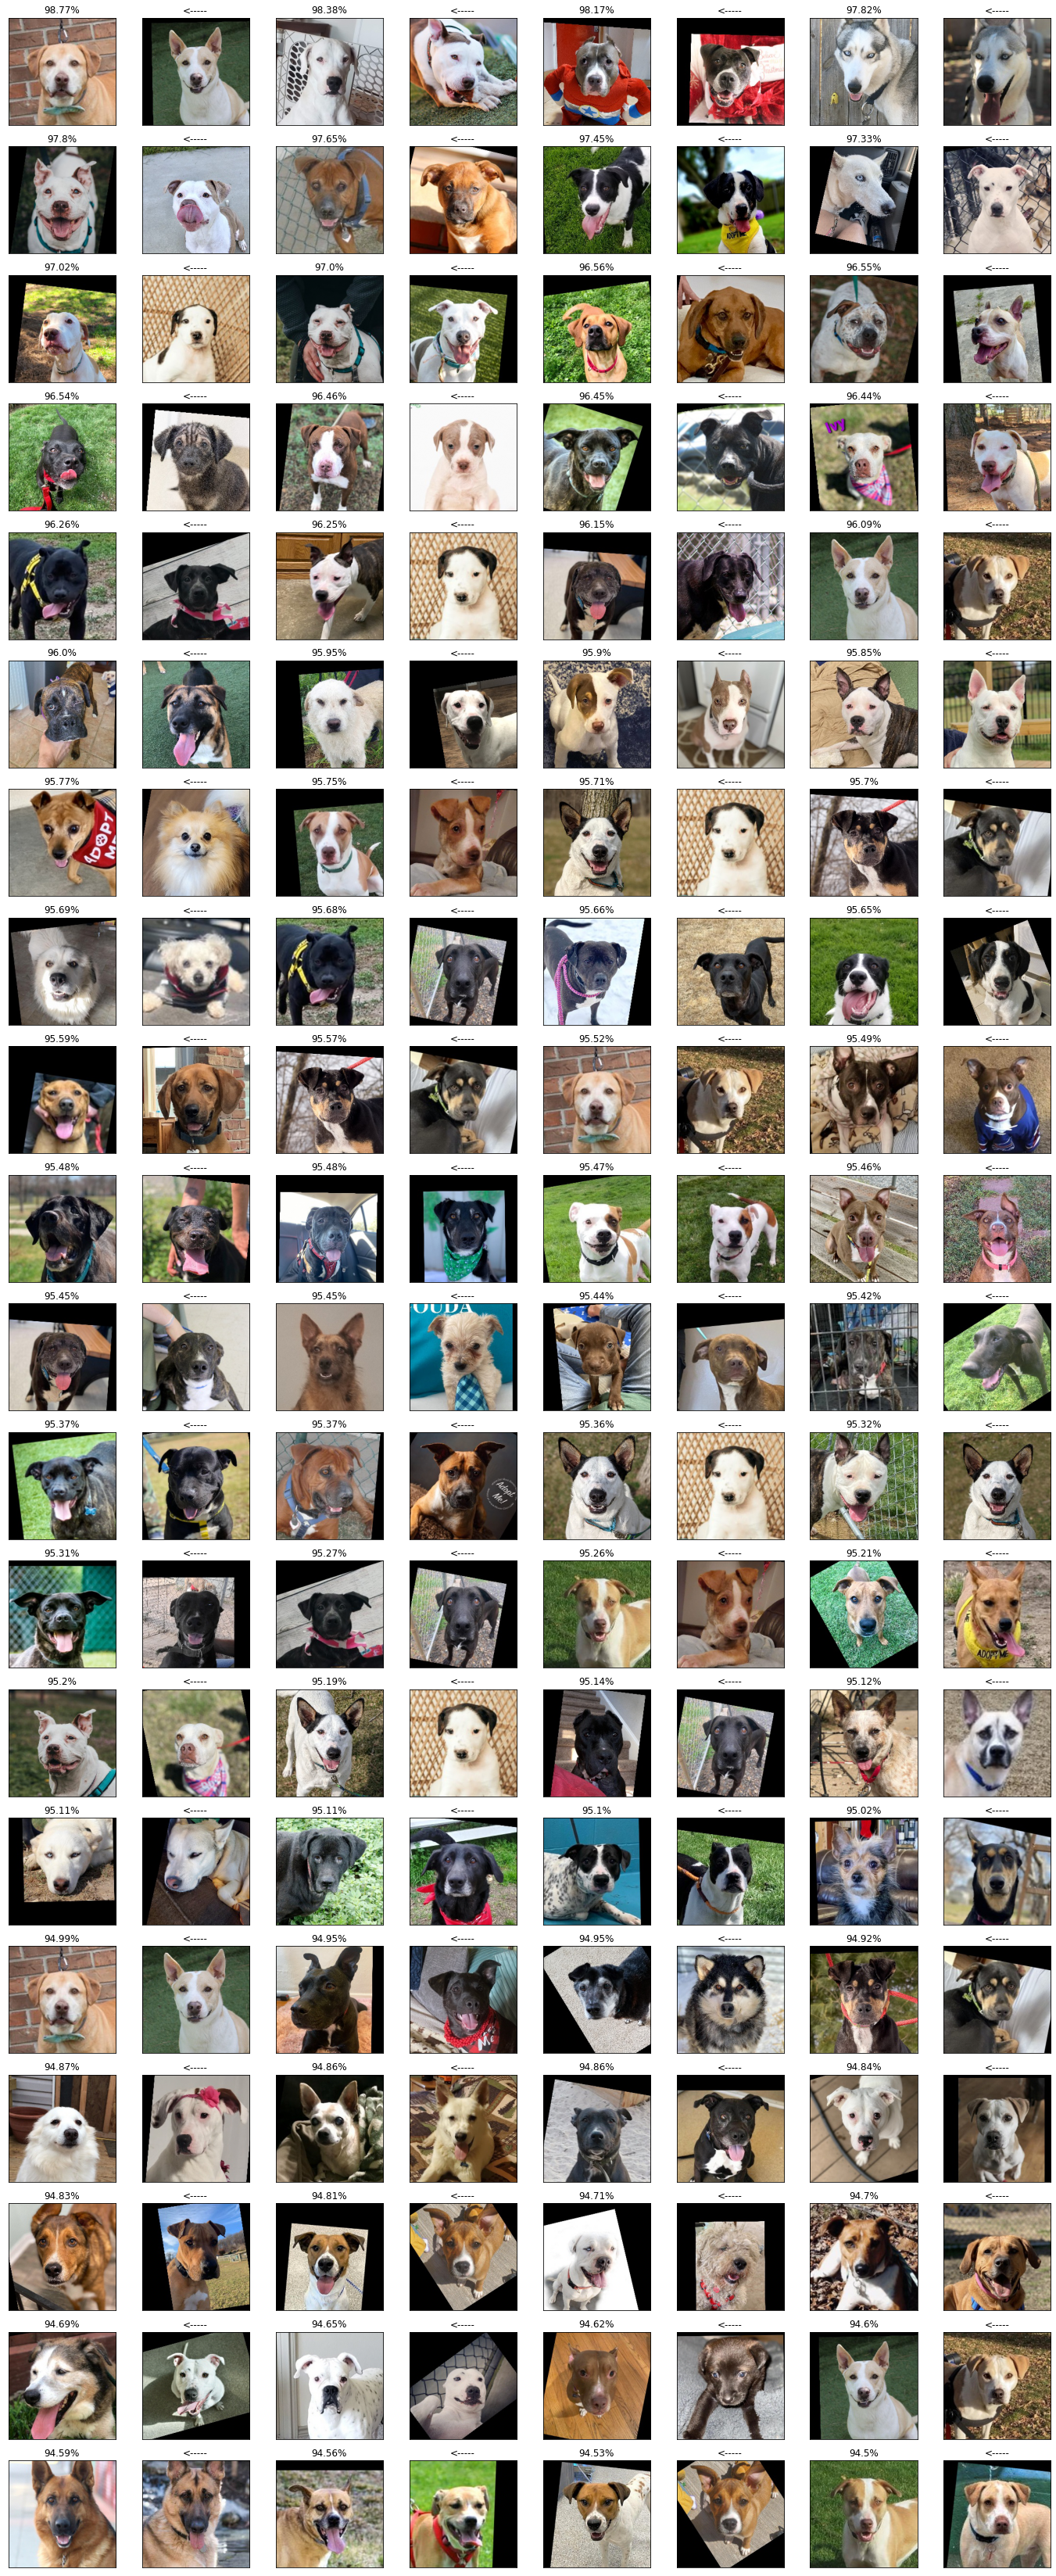

In [36]:
pair_to_show, reverse = (pairs_different_class, True) # mas cercanos
#pair_to_show, reverse = (pairs_different_class, False) # mas lejanos
#pair_to_show, reverse = (pairs_same_class, True) # mas cercanos
#pair_to_show, reverse = (pairs_same_class, False) # mas lejanos

def show_pairs(pairs):
  pairs = sorted(pairs, key=lambda x: x[8], reverse=reverse)
  images = []
  titles = []
  for pair in pairs[:80]:
    #print(pair[8])
    images.append(pair[2])
    titles.append(str(round(pair[8]*10000)/100) + "%")
    images.append(pair[6])
    titles.append("<-----")
  mostrar_imagenes(images, cols=8, titles=titles)

show_pairs(pair_to_show)